In [1]:
import datetime
import pandas as pd
import numpy as np
import sqlalchemy
from random import randint
import uuid
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
raw_trades = pd.read_csv('../raw_trade_data/futures_strategy.txt', sep='\t', parse_dates = ['DateTime'])
raw_trades.drop(columns = ['ActivityType', 'OrderActionSource', 'InternalOrderID', 'ServiceOrderID',
                      'TradeAccount', 'HighDuringPosition','LowDuringPosition','FillExecutionServiceID',
                      'ParentInternalOrderID','AccountBalance','OrderActionSource','Note','PositionQuantity',
                          'OrderStatus','Price2','Quantity','Price'], inplace=True)
raw_trades['Date'] = pd.to_datetime(raw_trades['DateTime']).dt.date
raw_trades['Position'] = raw_trades['FilledQuantity'] * np.where(raw_trades['BuySell'] == 'Sell', -1, 1)
raw_trades['CumulPos'] = raw_trades['Position'].cumsum()
raw_trades['TradeID'] = (raw_trades['CumulPos'] == 0).shift(1).fillna(0).cumsum() + 1
raw_trades['TradeDescription'] = np.where(raw_trades['CumulPos'] != 0 , "Entry","Exit")

In [3]:
raw_trades.head()

DateTime                 Symbol OrderType BuySell  FillPrice  FilledQuantity OpenClose        Date  Position  CumulPos TradeID TradeDescription
0 2019-09-02 14:08:36.810  MNQ-201909-GLOBEX-USD    Market    Sell    7653.50               1      Open  2019-09-02        -1        -1       1            Entry
1 2019-09-02 14:11:12.653  MNQ-201909-GLOBEX-USD      Stop     Buy    7656.50               1     Close  2019-09-02         1         0       1             Exit
2 2019-09-02 14:49:28.373  MNQ-201909-GLOBEX-USD    Market     Buy    7665.75               1      Open  2019-09-02         1         1       2            Entry
3 2019-09-02 14:59:31.406  MNQ-201909-GLOBEX-USD      Stop    Sell    7665.25               1     Close  2019-09-02        -1         0       2             Exit
4 2019-09-02 15:01:20.344  MNQ-201909-GLOBEX-USD    Market     Buy    7668.50               1      Open  2019-09-02         1         1       3            Entry

In [4]:
aggdict = {'DateTime':'max', 'FillPrice':'max'}
raw_trades.groupby(['Date','Symbol','TradeID','TradeDescription','BuySell']).agg(aggdict)
raw_trades.head()

DateTime                 Symbol OrderType BuySell  FillPrice  FilledQuantity OpenClose        Date  Position  CumulPos TradeID TradeDescription
0 2019-09-02 14:08:36.810  MNQ-201909-GLOBEX-USD    Market    Sell    7653.50               1      Open  2019-09-02        -1        -1       1            Entry
1 2019-09-02 14:11:12.653  MNQ-201909-GLOBEX-USD      Stop     Buy    7656.50               1     Close  2019-09-02         1         0       1             Exit
2 2019-09-02 14:49:28.373  MNQ-201909-GLOBEX-USD    Market     Buy    7665.75               1      Open  2019-09-02         1         1       2            Entry
3 2019-09-02 14:59:31.406  MNQ-201909-GLOBEX-USD      Stop    Sell    7665.25               1     Close  2019-09-02        -1         0       2             Exit
4 2019-09-02 15:01:20.344  MNQ-201909-GLOBEX-USD    Market     Buy    7668.50               1      Open  2019-09-02         1         1       3            Entry

In [5]:
transformed = pd.pivot_table(raw_trades, values= ['FillPrice', 'DateTime', 'BuySell'], index = ['Date','Symbol','TradeID'],
              columns = 'TradeDescription', aggfunc = np.max).reset_index()
transformed.columns = transformed.columns.droplevel()
transformed.columns = ['Date','Symbol','TradeID','EntryDir','ExitDir','EntryTime','ExitTime','EntryPrice','ExitPrice']
transformed['TickPL'] = (transformed['ExitPrice'] - transformed['EntryPrice'])/0.25 * np.where(transformed['EntryDir'] == 'Sell', -1, 1)
transformed.head()

Date                 Symbol  TradeID EntryDir ExitDir               EntryTime                ExitTime  EntryPrice  ExitPrice  TickPL
0  2019-09-02  MNQ-201909-GLOBEX-USD        1     Sell     Buy 2019-09-02 14:08:36.810 2019-09-02 14:11:12.653     7653.50    7656.50   -12.0
1  2019-09-02  MNQ-201909-GLOBEX-USD        2      Buy    Sell 2019-09-02 14:49:28.373 2019-09-02 14:59:31.406     7665.75    7665.25    -2.0
2  2019-09-02  MNQ-201909-GLOBEX-USD        3      Buy    Sell 2019-09-02 15:01:20.344 2019-09-02 15:02:46.264     7668.50    7666.50    -8.0
3  2019-09-02  MNQ-201909-GLOBEX-USD        4     Sell     Buy 2019-09-02 15:03:12.678 2019-09-02 15:06:07.686     7666.50    7656.00    42.0
4  2019-09-03  MNQ-201909-GLOBEX-USD        5      Buy    Sell 2019-09-03 11:42:04.728 2019-09-03 11:43:28.780     7635.25    7633.25    -8.0

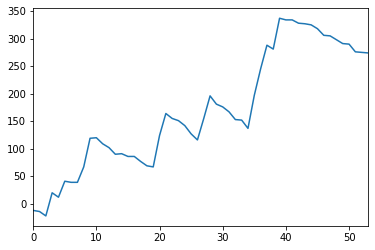

In [8]:
transformed['TickPL'].cumsum().plot()

In [7]:
transformed.to_pickle('../processed_trade_data/futures_strategy.pkl')